 ### Bayesian Statistics, Course Project 
# Kaggle challenge on particle physics
# Logistic regression with STAN and OSS undersampling
### Vanilla implementation


### Adrián Fernández Cid, Aitor Lucas Castellano, Marcos Moreno Blanco & Noel Rabella Gras
### 28-06-2021

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

The following code reproduces the treatment in *CERN-RandomSamples-Logistic-JAGS.ipynb*, but with our Recurrent Targetted Removal method for undersampling (implemented here with One-Sided-Selection) instead of the random one and excluding the horseshoe prior part due to its null contribution to performance. We refer to the said notebook for further details.

## Outline
### 1. Data exploration and preprocessing   
### 2. Vanilla logistic regression with STAN
#### 2.1. Modelling
#### 2.2. Evaluation 

## 1. Data exploration and preprocessing

We have a tabular dataset with information on particle collisions recorded at the LHCb experiment at CERN, and the objective is to identify the presence of a specific process: **the decomposition of $B_0$ into $K^0$**. We therefore have a binary classification problem, in which the focus is placed on the pòsitive signal. This last point suggests we keep an eye on recall (also known as sensitivity) to maximise true postives.

Since the meaning of the predictors is not obvious, we include their description here:

**B_FDCHI2_OWNPV**: Flight distance of the B meson with respect to the primary vertex (point of proton-proton collision).

**B_IPCHI2_OWNPV**: Impact parameter. Shortest distance between the B meson trajectory and the primary vertex.

**B_PT**: B meson transverse momentum

**PIMINUS** & **KPLUS PSEUDORAPIDITY**: Angle of the piminus and Kplus particles with respect to the beam axis.

**KPLUS** & **PIMINUS P**: Kplus and piminus momentum.

**KST_892_0_COSTHETAH**: K* helicity angle. Angle formed bewteen one of the particle products of K* (piminus or Kplus) and the B meson in the reference frame of the K* (rest frame)
GAMMA_PT: photon transverse momentum.

**KST_892_0_IP_OWNPV**: Impact parameter of K*, which corresponds to the shortest distance between the K* trajectory and the primary vertex.

**B_OWNPV_CHI2**: Chi2 test of the primary vertex distribution.

**KPLUS** & **PIMINUS IP_OWNPV**: Shortest distance between the Kplus or the piminus trajectory and the primary vertex.

**B_DIRA_OWNPV**: Corresponds to the cosine of the angle formed by the momentum of the B meson and the vector formed between the initial (primary vertex) and final position (decay vertex) of the B meson.

The data, published code and other details of the challenge are available at:
https://www.kaggle.com/c/cernsignal/overview.



In [106]:
# load required packages for the whole notebook
require(mcsm)
require(bayesplot)
require(dplyr)
#install.packages("Epi",dependencies=TRUE,repos="https://cloud.r-project.org")
require(Epi)
#install.packages("corrplot",dependencies=TRUE,repos="https://cloud.r-project.org")
require(corrplot)
#install.packages("R2jags",dependencies=TRUE,repos="https://cloud.r-project.org")
require(rstan)
#install.packages("pROC",dependencies=TRUE,repos="https://cloud.r-project.org")
require(pROC)
#install.packages("unbalanced",dependencies=TRUE,repos="https://cloud.r-project.org")
require(unbalanced)
require(caret)

Load labelled dataset (we will only use this):

In [107]:
train <- read.csv("data/train.csv")
names(train)
str(train)

[1] "Id"                  "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"     
 [4] "B_FDCHI2_OWNPV"      "B_DIRA_OWNPV"        "B_PT"               
 [7] "Kst_892_0_IP_OWNPV"  "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"     
[10] "Kplus_P"             "piminus_IP_OWNPV"    "piminus_P"          
[13] "gamma_PT"            "piminus_ETA"         "Kplus_ETA"          
[16] "BUTTER"              "signal"

'data.frame':	212662 obs. of  17 variables:
 $ Id                 : int  0 1 2 3 4 5 6 7 8 9 ...
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ BUTTER             : num  0.551 0.543 0.866 -0.443 -0.447 ...
 $ s

There are no NA (not available) values:

In [108]:
dim(train)
sum(is.na(train))
train=na.omit(train)
dim(train)
sum(is.na(train))

[1] 212662     17

[1] 0

[1] 212662     17

[1] 0

Remove **Id** (just an index) and **BUTTER** (an irrelevant column with butter consumption in Switzerland, purposely placed as a test). All other columns are numeric, so no need to factor any of them nor for a subsequent one-hot encoding.

In [109]:
data <- dplyr::select(train, -Id, -BUTTER)
# rename "signal" column to fit the rest of the code
names(data)[names(data) == 'signal'] <- 'Response'
str(data)

'data.frame':	212662 obs. of  15 variables:
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ Response           : num  1 1 1 0 0 0 1 0 0 0 ...


The variable **B_DIRA_OWNPV** seems to have little variability and therefore contain little information. We won't remove it just yet, but this is something to keep in mind:

In [110]:
summary(data$B_DIRA_OWNPV)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9995  1.0000  1.0000  1.0000  1.0000  1.0000 

Note the signal (presence of the process of interest $\equiv$ 1) is sparse:

In [111]:
n<-length(data$Response)
n
n1<-sum(data$Response)
n1
f<-n1/n
round(f,3)


[1] 212662

[1] 71030

[1] 0.334

This would have to be dealt with by giving a larger weight to the positive class, some resampling strategy (oversampling or undersampling techniques) to balance the data, or by a prior suitable for sparse signals such as the horseshoe. 

In the present case, as in the second assignment, JAGS (being an MCMC code) takes too long for the whole dataset, since it has to reevaluate the linear predictor $\eta$ *for all samples at every iteration*. This simplifies the choice: it means we have to undersample the original dataset. This bears the disadvantage of reducing the information available to the model (albeit information we could not have realistically used in its entirety anyway), and the question now is how to make the subsample maximally informative.

In this regard, the most obvious possibility is to randomly pick a perfectly balanced subset of data, effectively removing the imbalance problem: this is what we did in the second assignment and in *CERN-RandomSamples-Logistic-JAGS.ipynb*, but in this notebook we will try a more sophisticated strategy in order to select maximally informative samples: our Recurrent Targetted Removal (RDR) algorithm. As explained in the report, the RTR alternates between targetted removal (in this case, with One-Sided Selection) and random removal of a given percentage of samples, in an effort to maximise the number of samples selected by the more sophisticated strategy.

For the sake of rigour, we take as large a subsample as we reasonably can (2000 samples takes a little more than 30 min to process with JAGS -which we do a total of 3 times-, so we settle for that number) and repeat the process another 2 times for consistency checks (all with a fixed seed, for reproducibility).

To render the process more agile, we define a function that does the subsampling and one for the random subsampling sub-routine. The latter is:

In [112]:
subsample.class<-function(class, sample.size, seed=NULL){
    if (!is.null(seed)){set.seed(seed)}  # for reproducibility
    # positive subsamples
    row.idx <- sample(seq_len(nrow(class)),size = sample.size) # Randomly (uniform dist) identifies the rows equal to sample size from  all the rows of data and stores the row number in row.idx
    sample <- class[row.idx,] #creates the training dataset with row numbers stored in train.ind
    return(sample)
    }

And the RDR function is defined below. The input parameters are:

**data.** The dataset to be undersampled (a data frame).

**ref.size.** The reference size for the resubting subsample. Since the real final size varies depending on the parameter configuration, we default it to 2500 samples to make sure we get at least 2000.

**seed.** Random seed, for reproducibility.

**min.red** Lower bound on targetted removal reduction at each step, so that the code switches to random removal when it barely changes the current dataset.

**rand.frac.** Fraction of samples to preserve for each random removal.

**verbose.** Takes values 0, 1 or 2 in order of increasing verbosity.

**range.** Range of signal fraction to be imposed to targetted removal. Maniputaltion of this parameter and of min.red should be done with care, as some combinations will get the code stuck in the targetted removal loop.

**halt.cond.** To prevent the above problem, this number defines the maximum number of targetted removals of the first global iteration before halting execution and asking for a different combination of min.pred and range.

Note that, as mentioned in the report, random removal is performed only on the negative class in order to maximise the number of positive samples that are judiciously chosen.

In [113]:
RTR<-function(data, ref.size=2500, seed=4, min.red=500, rand.frac=0.7, verbose=1, range=c(0.4,0.6), halt.cond=30){
    if (!is.null(seed)){set.seed(seed)}  # for reproducibility
    X <- dplyr::select(data, -Response)
    Y <- data$Response
    sample.size<-length(Y)
    signal.fraction<-sum(Y)/sample.size
    #initialise counters
    count.oss<-0
    count.rand<-0
    tot.count<-0
    total.targetted.removals<-0
    total.random.removals<-0
    # reversed = TRUE when signal is inverted (0 to 1 and viceversa)
    reversed<-FALSE
    #halt flag, in case code gets stuck
    halt<-FALSE
    #initialise condition of outer while loop (containing targetted and random removal)
    cond1<-sample.size > ref.size | signal.fraction<range[1] | signal.fraction>range[2]
    #outtter (global) while loop
    while (cond1){
        #initialise condition of inner while loop (containing recursive targetted removal)
        reduction<-min.red+1
        cond2<-(sample.size > ref.size & reduction > min.red) | (signal.fraction<range[1] | signal.fraction>range[2])
        while (cond2){
            #subsample current data with chosen criterion
            subsample.oss<-ubOSS(X, Y, verbose = FALSE)
            #update X and Y and some indicators 
            X<-subsample.oss$X
            Y<-subsample.oss$Y
            reduction<-sample.size-length(Y)
            total.targetted.removals<-total.targetted.removals+reduction
            sample.size<-length(Y)
            #compute signal fraction according to whether ir is reversed or not
            if (!reversed){signal.fraction<-sum(Y)/sample.size}
            else {signal.fraction<-1-sum(Y)/sample.size}
            count.oss<-count.oss+1
            # if inputted extra verbosity (2), print info on the targetted subsampling
            if (verbose==2){
            cat("\nTotal count =", tot.count,"\nOSS count =", count.oss,
                        "\nRand count =", count.rand,"\nSample size =",sample.size, "\nReduction =", reduction, 
                        "\nSignal fraction =", signal.fraction,"\n")
            flush.console() #so that print appears in real time
            }
            if (count.oss>halt.cond & count.rand==0) {
                cat("\nStuck in targetted removal while loop: please change inputs 'min.red' and/or 'range'\n")
                flush.console()
                #halt flag, to break also from outter loop
                halt<-TRUE
                break
            }
            #update condition of inner while loop
            cond2<-(sample.size > ref.size & reduction > min.red) | (signal.fraction<range[1] | signal.fraction>range[2])

        }
        #break from outter loop to halt algorithm if got stuck in inner loop
        if (halt) {
            break
        }
        #if signal was not already reversed (1st iteration), reverse it and change the 
        #state of the flag accordingly
        if (!reversed){
            Y<-Y+1
            Y[Y==2]<-0
            reversed<-TRUE
        }
        #if desired sample.size not met after targetted removal, do random removal
        if (sample.size>ref.size){
            Response<-Y
            df<-cbind(X,Response)
            #retrieve positives and negatives (with reversed signal)
            positives=subset(df, df$Response==0)
            negatives=subset(df, df$Response==1)
            neg.size<-dim(negatives)[1]
            #randomly remove a percentage of negative instances
            sub.neg<-subsample.class(negatives, round(rand.frac*neg.size)
                                     #, seed
                                    )
            df<-rbind(positives, sub.neg)
            #update X, Y and some indicators
            X<-dplyr::select(df, -Response)
            Y<-df$Response
            reduction<-sample.size-length(Y)
            total.random.removals<-total.random.removals+reduction
            sample.size<-length(Y)
            signal.fraction<-1-sum(Y)/sample.size
            count.rand<-count.rand+1 
            }
        tot.count<-tot.count+1
        #if verbose input is default (1) or more, print some useful info
        if (verbose>0){
            cat("\nTotal count =", tot.count,"\nOSS count =", count.oss,"\nRand count =", count.rand,"\nSample size =", 
                                           sample.size,"\nSignal fraction =", signal.fraction, "\n")
            flush.console() #so that print is shown in real time
        }
        #update condition of outter while loop
        cond1<-sample.size > ref.size | signal.fraction<range[1] | signal.fraction>range[2]
    }
    #undo the signal inversion
    Y<-Y+1
    Y[Y==2]<-0
    sum(Y)/length(Y)
    #obtain resulting train and test subsamples, and return them along with total numbers 
    #of random and targetted removals
    #note the undersampling process conserves the original row indices, so we 
    #can use them to obtain the test subset as the complementary of the train one
    Response<-Y
    train.sub<-cbind(X, Response)
    row.idx<-as.integer(row.names(train.sub))
    test.sub<-data[-row.idx,]
    return(list("train"=train.sub, "test"=test.sub, "targetted"=total.targetted.removals,
           "random"=total.random.removals))

}

Now, we produce our three subsamples (this takes us 15-20 min each time). For speed, one can also load them from the previously saved files (see below).

In [50]:
rand.frac<-0.8
range<-c(0.40, 0.60)

In [51]:
seed<-4
start.time <- Sys.time()
subsample.01<-RTR(data, ref.size = 100, rand.frac=rand.frac, range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

In [ ]:
seed<-44
start.time <- Sys.time()
subsample.02<-RTR(data, ref.size = 100, rand.frac=rand.frac, range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

In [ ]:
seed<-444
start.time <- Sys.time()
subsample.03<-RTR(data, ref.size = 100, rand.frac=rand.frac, range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

In [ ]:
subsample.01$targetted
subsample.01$random
train.01<-subsample.01$train
test.01<-subsample.01$test

subsample.02$targetted
subsample.02$random
train.02<-subsample.02$train
test.02<-subsample.02$test

subsample.03$targetted
subsample.03$random
train.03<-subsample.03$train
test.03<-subsample.03$test

Note that roughly 3 times as many samples as those removed randomly have been removed with the targetting method: as we comment on in the report, this is in principle much better than just performing targetted removal a first series of times (that still leaves a dataset of around 120 000 samples) and then simply randomly removing excess samples. Also, the final proportion of the signal is a bit over the negative one, but such imbalance is less than at the beginning and, most importantly, it favours the positive signal, which is the one we are interested in.

Since producing the subsamples takes some time, we write the train indices to csv files:

In [114]:
row.idx<-as.integer(row.names(train.01))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/oss_train_idx_01.csv", row.names=FALSE)

row.idx<-as.integer(row.names(train.02))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/oss_train_idx_02.csv", row.names=FALSE)

row.idx<-as.integer(row.names(train.03))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/oss_train_idx_03.csv", row.names=FALSE)

And we can load the saved train indices and define train and test subsamples as follows (you can do this if you prefer to avoid recomputing them):

In [115]:
row.idx<-read.csv(file="data/oss_train_idx_01.csv")
train.01<-data[row.idx$x,]
test.01<-data[-row.idx$x,]

row.idx<-read.csv(file="data/oss_train_idx_02.csv")
train.02<-data[row.idx$x,]
test.02<-data[-row.idx$x,]

row.idx<-read.csv(file="data/oss_train_idx_03.csv")
train.03<-data[row.idx$x,]
test.03<-data[-row.idx$x,]

str(train.01)

'data.frame':	2432 obs. of  15 variables:
 $ B_OWNPV_CHI2       : num  29.3 25.9 38.1 35.8 52.6 ...
 $ B_IPCHI2_OWNPV     : num  4.411 3.956 3.616 1.191 0.125 ...
 $ B_FDCHI2_OWNPV     : num  24534 175 5418 5231 3762 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  4786 16327 14360 4144 5608 ...
 $ Kst_892_0_IP_OWNPV : num  2.57 0.215 0.982 1.26 0.667 ...
 $ Kst_892_0_cosThetaH: num  -0.301 -0.128 0.719 -0.188 -0.561 ...
 $ Kplus_IP_OWNPV     : num  3.168 0.231 0.941 1.143 0.659 ...
 $ Kplus_P            : num  13950 46468 17634 28012 38458 ...
 $ piminus_IP_OWNPV   : num  1.889 0.184 1.037 2.062 0.877 ...
 $ piminus_P          : num  11227 25478 21831 5561 5575 ...
 $ gamma_PT           : num  5095 4815 6127 3938 3239 ...
 $ piminus_ETA        : num  3.76 2.48 2.2 2.84 2.84 ...
 $ Kplus_ETA          : num  3.07 2.47 2.17 3.53 3.17 ...
 $ Response           : num  1 1 1 1 1 1 1 1 1 1 ...


Format train subsamples for JAGS:

In [116]:
# Convert factors to one-hot indicators
x.01<-model.matrix(Response~.,train.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
y.01<-train.01$Response
#check x.01 is indeed ohe'd (eg see "Vehicle_Age")
#head(x.01)
x.02<-model.matrix(Response~.,train.02)[,-1] 
y.02<-train.02$Response

x.03<-model.matrix(Response~.,train.03)[,-1] 
y.03<-train.03$Response

In [117]:
n<-length(y.01)
n
table(y.01)
#summary(x).01
n1<-sum(y.01)
f<-n1/n
round(f,3)

[1] 2432

y.01
   0    1 
 976 1456 

[1] 0.599

As we have seen in class, non-standardised data yields instability, so let us standardise x. Again, for agility, we define a function to do it:

In [118]:
standardise<-function(x){
    #compute means of every column (2 for columns, 1 for rows)) of X
    xm<-apply(x,2,mean)
    # center each column by substracting its mean
    xc<-sweep(x,2,xm,"-")
    # get standard dev of columns of xc
    xs<-apply(xc,2,sd)
    # standardise xc by dividing each column by its sd
    x0<-sweep(xc,2,xs,"/")
    return(x0)}

In [119]:
x0.01<-standardise(x.01)
x0.02<-standardise(x.02)
x0.03<-standardise(x.03)
#head(x0.01)
# check that all vertical means of x0.01 are indeed 0
round(max(abs(apply(x0.01,2,mean))),6) 
# check that indeed sd's of columns of x0.01 are 1
round(apply(x0.01,2,sd), 5)

[1] 0

B_OWNPV_CHI2      B_IPCHI2_OWNPV      B_FDCHI2_OWNPV        B_DIRA_OWNPV 
                  1                   1                   1                   1 
               B_PT  Kst_892_0_IP_OWNPV Kst_892_0_cosThetaH      Kplus_IP_OWNPV 
                  1                   1                   1                   1 
            Kplus_P    piminus_IP_OWNPV           piminus_P            gamma_PT 
                  1                   1                   1                   1 
        piminus_ETA           Kplus_ETA 
                  1                   1

The condition number $\kappa$ is indeed much smaller after standardisation, meaning a more stable regression:

In [120]:
#have to take the intercept into account as well for the condition number
x1.01<-cbind(rep(1,n),x.01)
x01.01<-cbind(rep(1,n),x0.01)
round(kappa(x1.01),1)
round(kappa(x01.01),1)

[1] 1339172188

[1] 12.7

Another thing we should do is check the correlation between predictors (i.e. colinearity, which is invariant under centering and scaling). One should do it for all the available data, so we obtain a suitable dataframe:

In [121]:
colnames(data)[15]

[1] "Response"

In [122]:
x.corr<-model.matrix(Response~.,data)[,-1]
cn<-colnames(x.corr)
x.corr<-cbind(x.corr, data[, 15]) # add Response column
colnames(x.corr)<-c(cn, "Response")
str(x.corr)
#head(x.corr)

 num [1:212662, 1:15] 28.9 34.2 36.1 14.3 60.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:212662] "1" "2" "3" "4" ...
  ..$ : chr [1:15] "B_OWNPV_CHI2" "B_IPCHI2_OWNPV" "B_FDCHI2_OWNPV" "B_DIRA_OWNPV" ...


Note we have included the response in x.corr. this will give us a first hint of which predictors are most important for the classification. The plot of the correlation matrix is:

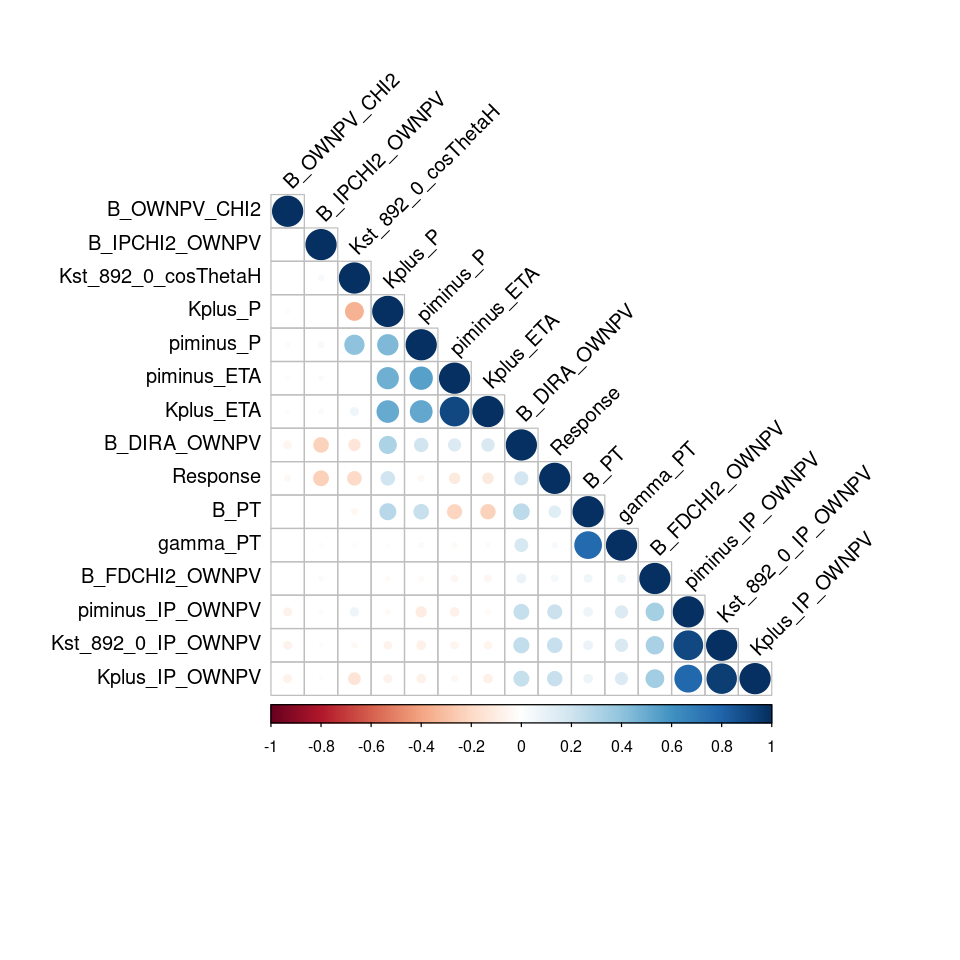

In [123]:
options(repr.plot.width=8,repr.plot.height=8)
corrplot(cor(x.corr), type="lower", order="hclust", tl.col="black", tl.srt=45)

Looks like we have remarkable positive correlation in the pairs **piminus_ETA/Kplus_ETA**, **B_PT/gamma_PT** and the triplet **piminus_IP_OWNPV/Kst_892_0_IP_OWNPV/Kplus_IP_OWNPV**, and negative correlation in the pairs **Kplus_P/Kst_892_0_cosThetaH**, **Kplus_IP_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/B_IPCHI2_OWNPV**, **B_PT/piminus_ETA** and **B_PT/Kplus_ETA**.

Regarding the response, it has strong negative correlation with **Kst_892_0_cosThetaH** and with **B_IPCHI2_OWNPV**.

## 2. Vanilla logistic regression with STAN

### 2.1. Modelling

We have decided to include this case for reference, so that we can better gauge the later contribution of the horseshoe.
As in Week 12's *GLM.01.Logistic.Challenger.ipynb*, we have centered Gaussian priors for the logistic coefficients $\beta_i$, all with $\sigma = 10$, thus precision $\tau = 0.01$ (the same we use in the horseshoe case for $\beta_0$, for the sake of comparison). The likelihood of the logistic regression is, as seen in the mentioned notebook, a Bernoulli distribution with probability $p_i$ given by the logistic function. More graphically:

$$
    \begin{array}{lclcll}
        y_{i}           &\sim    &Bern(p_i),&&&1\leq i\leq n,\\[0.2cm]
         p_i &=      &\operatorname{Logistic}(\eta_i) =\dfrac{\exp(\eta_i)}{1+\exp(\eta_i)},&&&1\leq i\leq n,\\[0.2cm]
        \eta_{i}         &=     &\beta_{0}+x_{i\,\cdot\,}\cdot \beta,\mskip45mu  &&&1\leq i\leq n,\\[0.2cm]
        \beta_{j}        &\sim   &\normaldist(0,1.0E01), &&0\leq j\leq p,\\[0.2cm]
    \end{array}
$$


Define the STAN model (very similar to what we did with the Challenger data):

In [124]:
model.string<-"
data {
  int<lower=0> N;  
  int<lower=0> p;
  int<lower=0,upper=1> y[N];
  matrix[N,p] X;
}
parameters {
  vector[p] beta;
}

model {
  for (n in 1:N)
     y[n]~ bernoulli_logit( X[n,] * beta );
}"

Define parameters and data (this one for each initial subsample), and the corresponding models:

In [125]:
n1<-dim(x0.01)[1]
n2<-dim(x0.02)[1]
n3<-dim(x0.03)[1]

p<-dim(x0.01)[2]

data.01 <-list(X = x0.01, y=y.01, N=length(y.01), p<-p)
data.02 <-list(X = x0.02, y=y.02, N=length(y.02), p<-p)
data.03 <-list(X = x0.03, y=y.03, N=length(y.03), p<-p)



Run one chain per model with 20 000 iterations and a burnout of the 5000 (see summary(sample.01)) initial samples (those that will be discarded to assure randomness of MCMC sampling). Note that this takes 30-40 min for each of the three subsamples.

In [126]:
start.time <- Sys.time()

sample.01 <- stan(model_code = model.string, data = data.01, iter = 20000,
             chains = 1, verbose = FALSE, seed=101, warmup=5000)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


SAMPLING FOR MODEL '5ac535c69ad0c5d6f40a50e6be0c8087' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000997 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 9.97 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1: Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1: Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1: Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1: Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1: Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1: Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1: Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1: Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 94.1552 seconds (Warm-up)
Chain 1:              

Time difference of 6.574529 mins

In [129]:
start.time <- Sys.time()

sample.02 <- stan(model_code = model.string, data = data.02, iter = 20000,
             chains = 1, verbose = FALSE, seed=101, warmup=5000)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


SAMPLING FOR MODEL '5ac535c69ad0c5d6f40a50e6be0c8087' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000665 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 6.65 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1: Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1: Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1: Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1: Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1: Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1: Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1: Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1: Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 122.648 seconds (Warm-up)
Chain 1:              

Time difference of 9.051696 mins

In [130]:
start.time <- Sys.time()

sample.03 <- stan(model_code = model.string, data = data.03, iter = 20000,
             chains = 1, verbose = FALSE, seed=101, warmup=5000)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


SAMPLING FOR MODEL '5ac535c69ad0c5d6f40a50e6be0c8087' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000791 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.91 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1: Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1: Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1: Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1: Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1: Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1: Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1: Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1: Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 106.205 seconds (Warm-up)
Chain 1:              

Time difference of 7.844713 mins

Visualise output:

In [131]:
summary(sample.01)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],0.0719702,0.0003595111,0.05082342,-2.799961e-02,3.842308e-02,7.154198e-02,1.054023e-01,0.1719948,19984.957,0.9999909
beta[2],-0.4630533,0.0003973263,0.05509751,-5.729442e-01,-4.995627e-01,-4.623306e-01,-4.253777e-01,-0.3561329,19229.563,0.9999333
beta[3],-0.5931877,0.0007046933,0.09226286,-7.752750e-01,-6.556649e-01,-5.924508e-01,-5.312217e-01,-0.4144858,17141.686,0.9999333
beta[4],0.2809350,0.0006490439,0.08471216,1.229294e-01,2.217925e-01,2.782208e-01,3.376872e-01,0.4507571,17035.049,0.9999348
beta[5],-0.1180378,0.0021324111,0.19663629,-5.045056e-01,-2.491148e-01,-1.174956e-01,1.492434e-02,0.2602232,8503.260,0.9999422
beta[6],0.7969991,0.0030538760,0.32424570,1.557183e-01,5.785631e-01,7.974323e-01,1.014942e+00,1.4286053,11273.160,1.0000290
beta[7],-0.4012238,0.0009007094,0.09692424,-5.937896e-01,-4.661691e-01,-4.008529e-01,-3.358127e-01,-0.2111889,11579.649,0.9999510
beta[8],0.2366116,0.0021168118,0.23254017,-2.070359e-01,7.679788e-02,2.280725e-01,3.924169e-01,0.6982499,12067.894,0.9999965
beta[9],0.6156217,0.0012795060,0.12453062,3.749865e-01,5.311472e-01,6.161135e-01,6.997313e-01,0.8593788,9472.566,0.9999333
beta[10],0.4246341,0.0017214394,0.18492247,5.855594e-02,3.029921e-01,4.251074e-01,5.490072e-01,0.7881942,11539.736,0.9999666


In [132]:
# summary(sample.02)

In [133]:
#summary(sample.03)

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



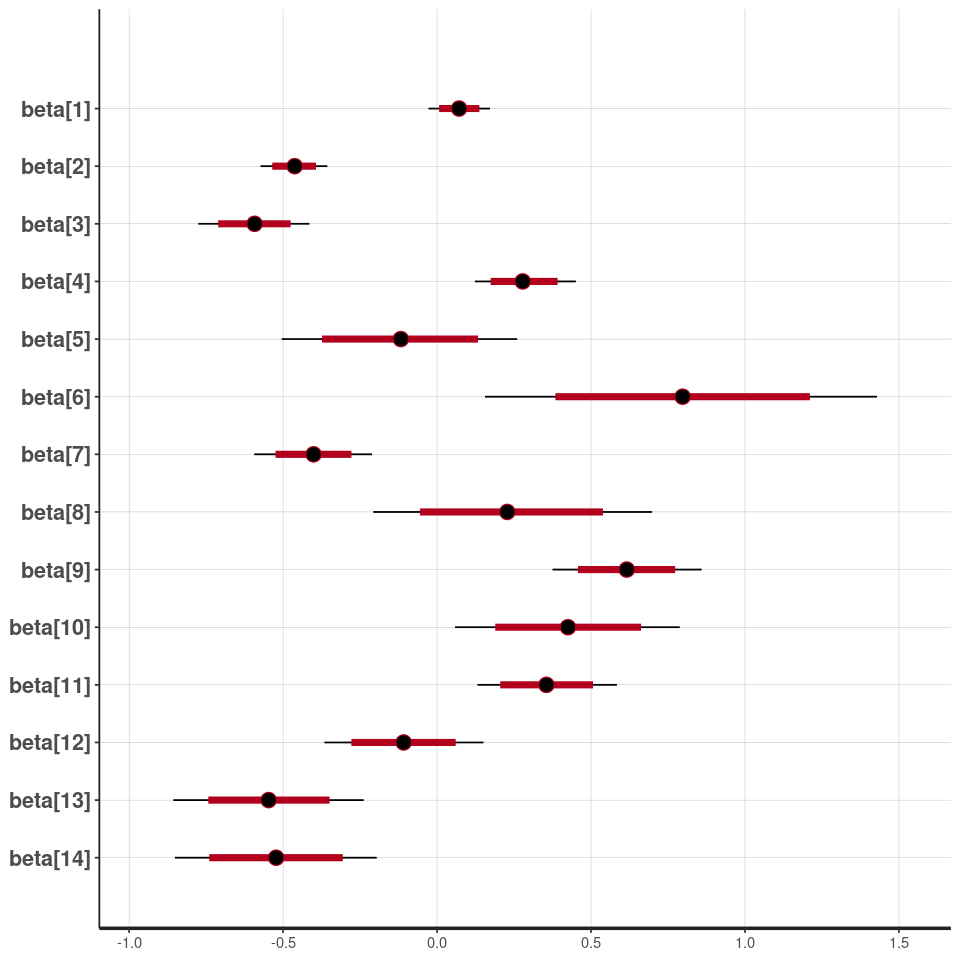

In [134]:
plot(sample.01, pars = 'beta')

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



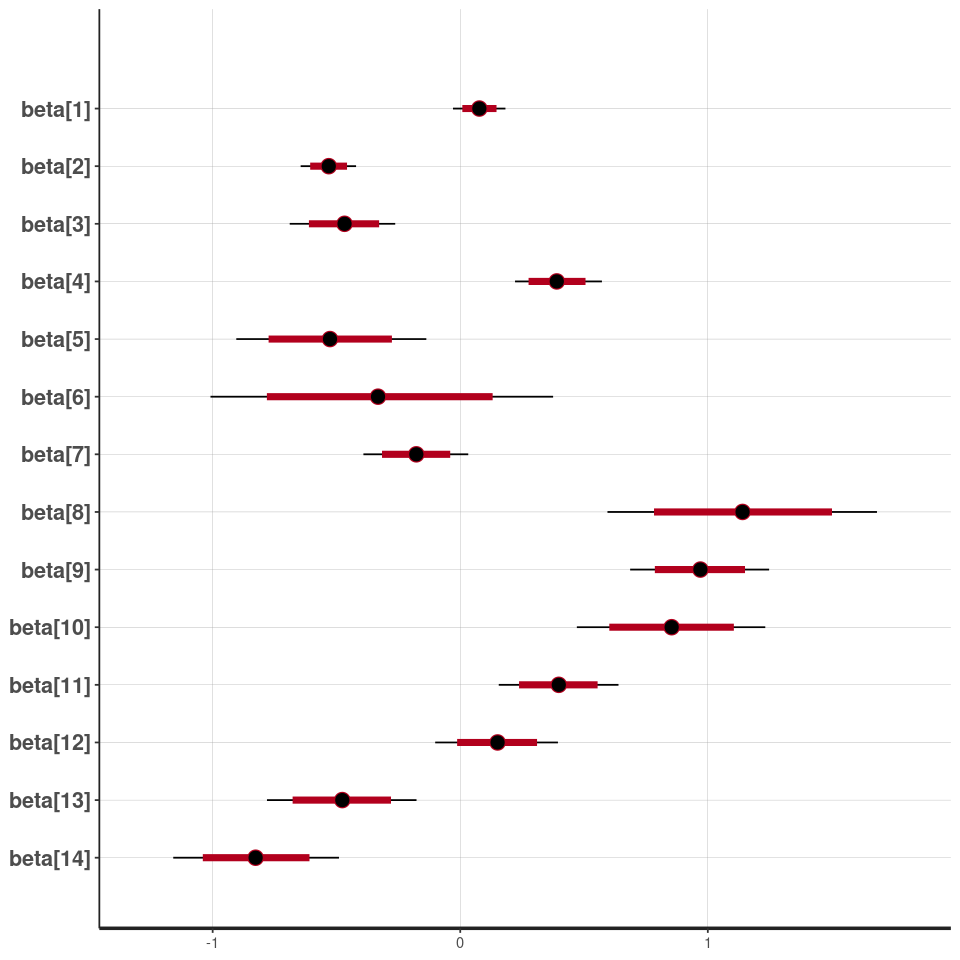

In [135]:
plot(sample.02, pars = 'beta')

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



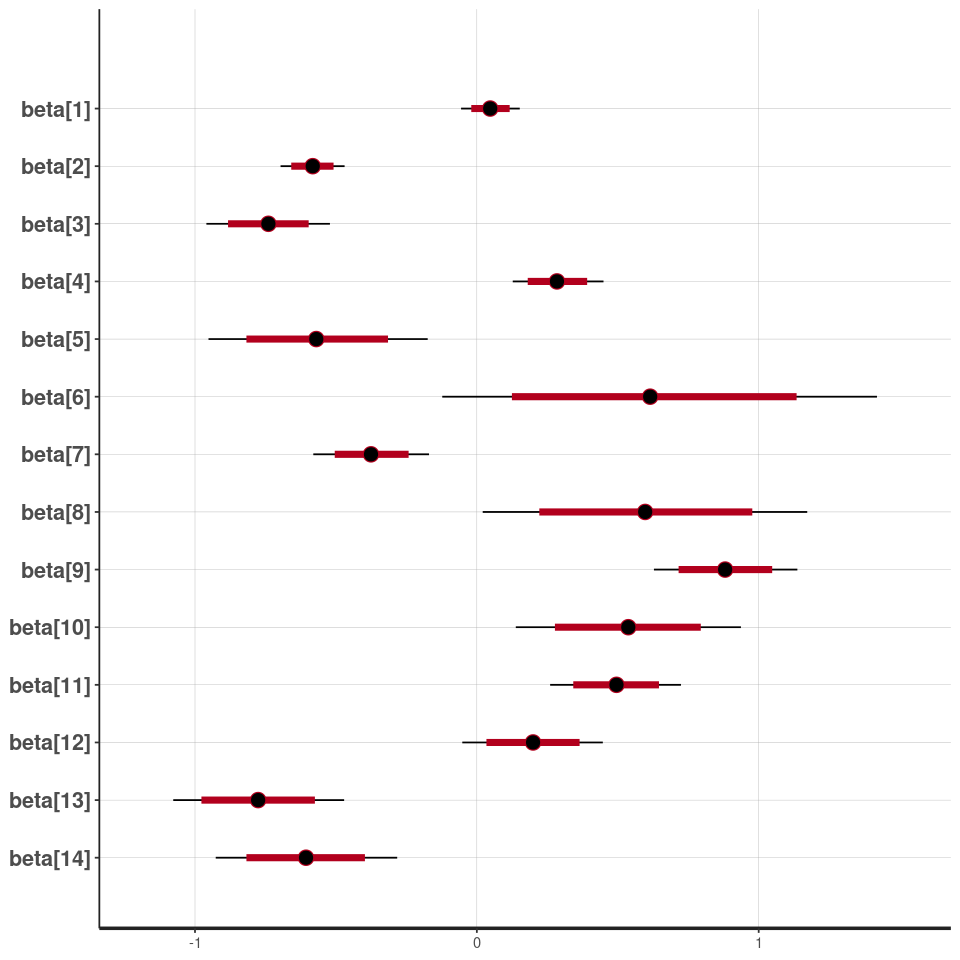

In [136]:
plot(sample.03, pars = 'beta')

The overall noisy traceplots show that posteriors are correctly sampled.

To check for consistency among initial subsamples, we look at the mean posterior values of the logistic parameters ($\beta_0$ and $\beta$) for each of them. As several times before, we define a function to do it:

In [137]:
print('Coefficients from sample.01:')
print(colMeans(as.matrix(sample.01))[1:15])
cat('\n')
print('Coefficients from sample.02:')
print(colMeans(as.matrix(sample.02))[1:15])
cat('\n')
print('Coefficients from sample.03:')
print(colMeans(as.matrix(sample.03))[1:15])

[1] "Coefficients from sample.01:"
      beta[1]       beta[2]       beta[3]       beta[4]       beta[5] 
    0.0719702    -0.4630533    -0.5931877     0.2809350    -0.1180378 
      beta[6]       beta[7]       beta[8]       beta[9]      beta[10] 
    0.7969991    -0.4012238     0.2366116     0.6156217     0.4246341 
     beta[11]      beta[12]      beta[13]      beta[14]          lp__ 
    0.3557057    -0.1089591    -0.5460494    -0.5224918 -1217.6120924 

[1] "Coefficients from sample.02:"
      beta[1]       beta[2]       beta[3]       beta[4]       beta[5] 
 7.738637e-02 -5.315933e-01 -4.694066e-01  3.912388e-01 -5.251309e-01 
      beta[6]       beta[7]       beta[8]       beta[9]      beta[10] 
-3.275482e-01 -1.775665e-01  1.141217e+00  9.683410e-01  8.533146e-01 
     beta[11]      beta[12]      beta[13]      beta[14]          lp__ 
 3.978996e-01  1.499630e-01 -4.776006e-01 -8.255914e-01 -1.135832e+03 

[1] "Coefficients from sample.03:"
      beta[1]       beta[2]       beta[3]

In [138]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

The posterior means are less consistent across subsamples than in the random case, which is puzzling considering an important franction of instances is obtained with the same targetted criterion for each subsample. Although this result may seem unsatisfactor, note that taking a greater subsample size would yield an unreasonable execution time for the notebook. 

### 2.2. Evaluation

To evaluate the model, we consider the train and test deviance, AIC and BIC. Since in this case we are applying Bayesian inference to a classification problem, we also compute the area under de ROC curve, which has the advantage over the latter that it is bounded and has absolute meaning (whereas deviation, AIC and BIC increase indefinitely with the size of the dataset used). Having established at the beginning of the notebook that we are mostly interested in true positives, we also look at recall (a.k.a. sensitivity, the fraction of total positives predicted as such): although we will show the other metrics for completeness, we will concentrate on AUC and recall, the latter computed for the optimal operating point of the ROC curve.

Note that for the test we use all samples not included in the corresponding 2000 train subsample, so **we test with about 210 000 samples** each time. We do this to put to use all available information, and we can afford to do so at test because we are just evaluating the logistic function (what took so long at train was the MCMC sampling).

Since, once again, we wil do this several times, we define a function to compute and print all relevant evaluation metrics. In the case of the train phase, we also print the deviance, AIC and BIC computed by JAGS, for reference.

In [139]:
evaluate<-function(sample, x, y, phase, threshold=NULL){
    n<-dim(x)[1]    
    n.pars<-dim(x)[2]
    b<-colMeans(as.matrix(sample))[1:14]
    #probabilities
    eta.bar<-as.numeric(as.matrix(x) %*% b)
    p.bar<-1/(1+exp(-eta.bar))
    #log-likelihood
    logL.hat<-sum(y * log(p.bar) + (1 - y) * log(1 - p.bar))
    #AUC
    roc_obj <- roc(y, p.bar)
    AUC.hat<-auc(roc_obj)
    cat("\n", phase,"AUC:", round(AUC.hat,4)) 
    #deviance
    D.hat<- -2*logL.hat
    cat("\n", phase,"Deviance:", round(D.hat,4))  
    #AIC
    AIC.hat<-D.hat+2*n.pars
    cat("\n", phase,"AIC:", round(AIC.hat,4))  
    #BIC
    BIC.hat<-D.hat+log(n)*n.pars
    cat("\n", phase,"BIC:", round(BIC.hat,4))  
    #if training phase, print JAGS quantities as well for comparison
    if (phase=="train"){ 
        #compute threshold and recall/sensitivity for best operating point
        #in ROC curve
        rc <- ROC(test=p.bar, stat = as.logical(y), plot="ROC", main="Train ROC curve") 
        # optimal combination
        opt <- which.max(rowSums(rc$res[, c("sens", "spec")]))
        # optimal cut-off point and corresponding recall
        threshold = as.numeric(names(opt))
        recall<-rc$res$sens[opt]
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
        return(threshold)
        } else{
        check<-y+p.bar
        true.p<-0
        total.p<-sum(y)
        for (num in check){
            if (num >= (1+threshold)){
            true.p<-true.p+1    
            }
        }
        recall<-true.p/total.p
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
            
        }
    
    }

Having our function, we call it for the result obtained for each original subsample:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8507
 train Deviance: 2421.234
 train AIC: 2449.234
 train BIC: 2530.384
 train recall/sensitivity 0.8187

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7701
 test Deviance: 266293
 test AIC: 266321
 test BIC: 266464.6
 test recall/sensitivity 0.8356

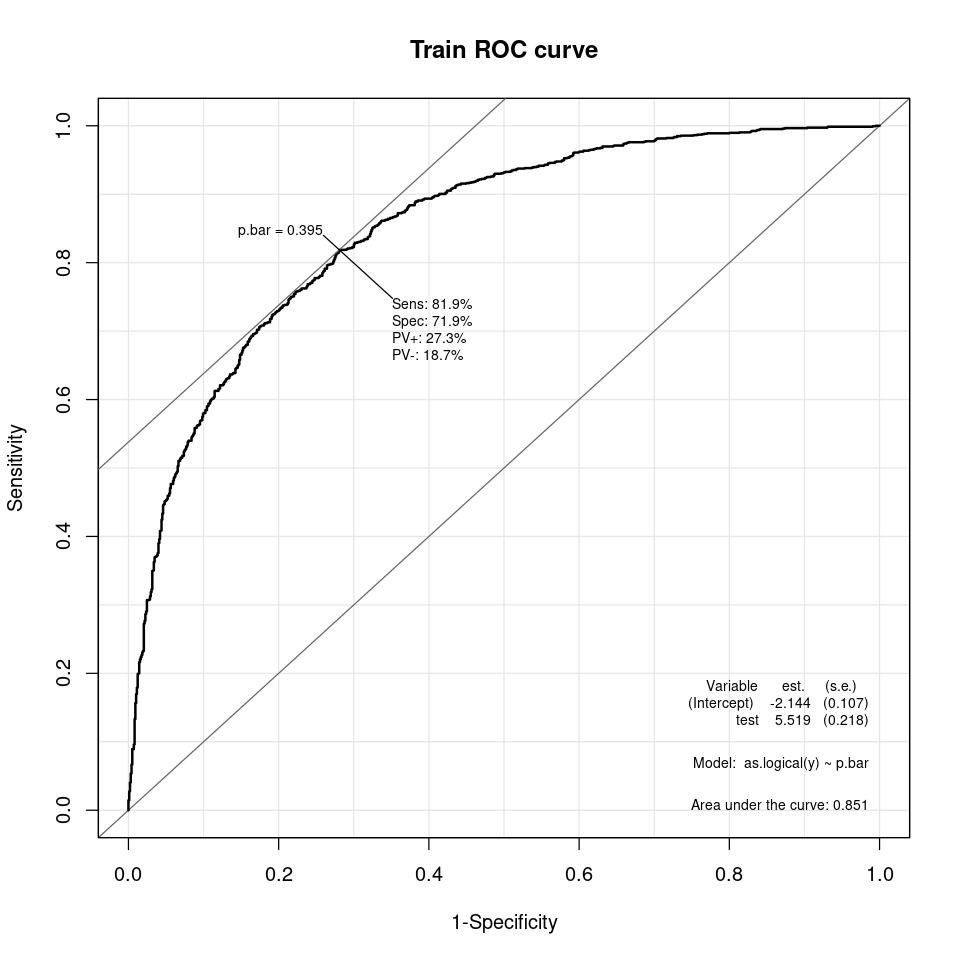

In [140]:
#evaluate train
thr<-evaluate(sample.01, x0.01, y.01, phase="train")
# evaluate test
xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8725
 train Deviance: 2257.632
 train AIC: 2285.632
 train BIC: 2366.673
 train recall/sensitivity 0.7927

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7692
 test Deviance: 273817.6
 test AIC: 273845.6
 test BIC: 273989.2
 test recall/sensitivity 0.787

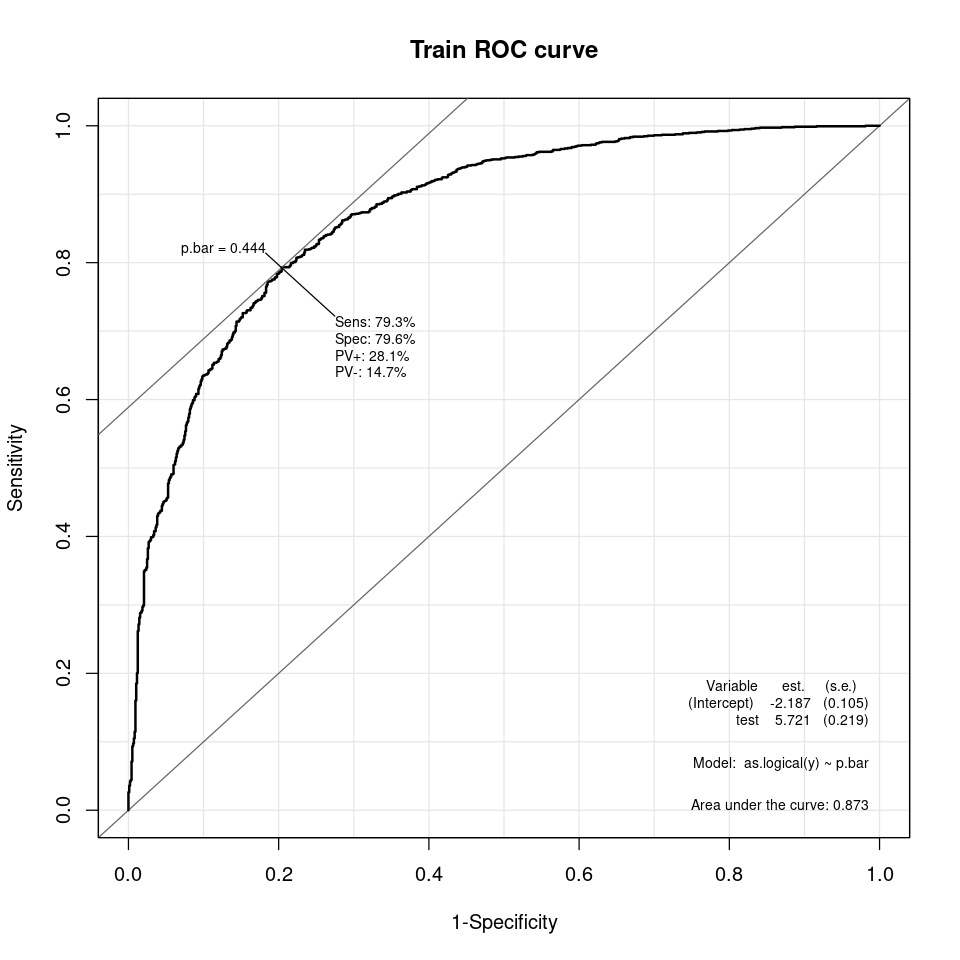

In [141]:
thr<-evaluate(sample.02, x0.02, y.02, phase="train")

xt<-model.matrix(Response~.,test.02)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.02$Response
evaluate(sample.02, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8679
 train Deviance: 2278.873
 train AIC: 2306.873
 train BIC: 2387.908
 train recall/sensitivity 0.8366

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.772
 test Deviance: 274440.7
 test AIC: 274468.7
 test BIC: 274612.3
 test recall/sensitivity 0.8208

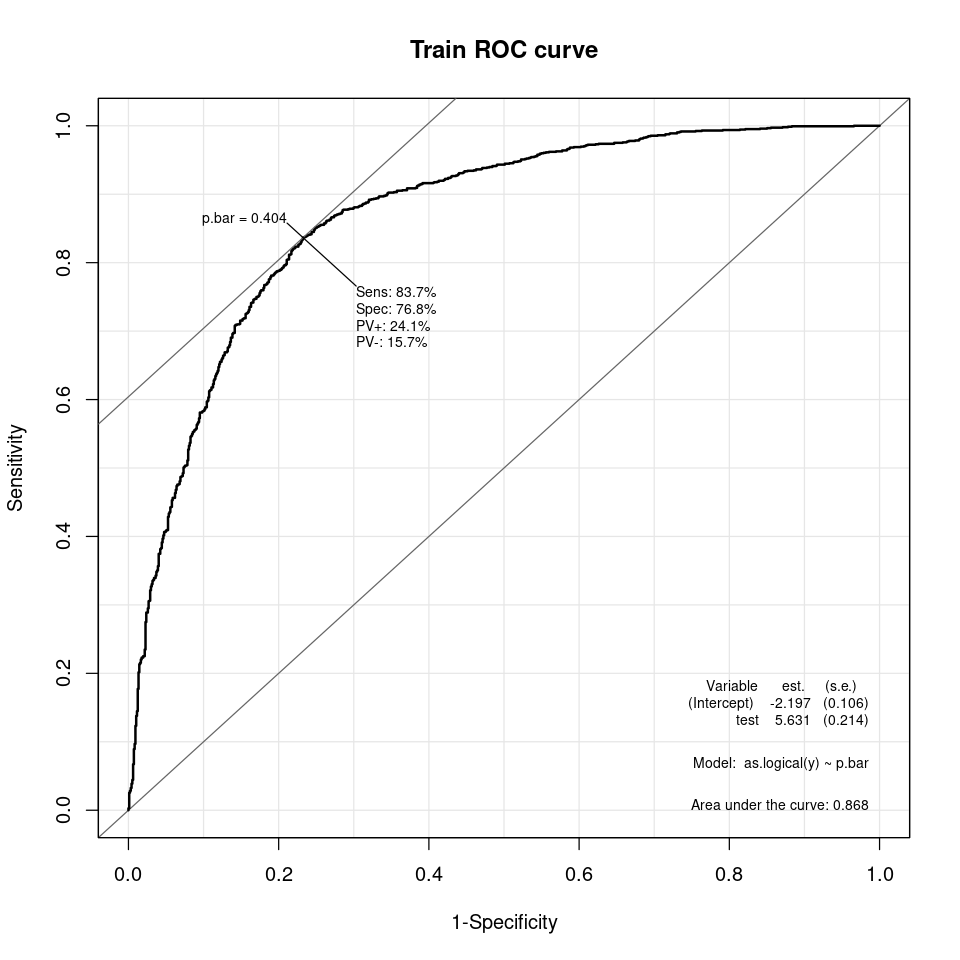

In [142]:
thr<-evaluate(sample.03, x0.03, y.03, phase="train")

xt<-model.matrix(Response~.,test.03)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.03$Response
evaluate(sample.03, xt, yt, phase="test", threshold = thr)

We get similar test AUCs across subsamples (0.77), while test recall varies from 0.77 to 0.80. Not good, considering performance is similar to or even poorer than that of the random removal case: we were hoping for this more sophisticated undersampling strategy to improve results.

The similarity across subsamples here, however, contributes to validating their size.